In [3]:
# !pip install --upgrade pip
# !pip install tensorflow-macos


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [4]:
# Load dependencies
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from functions import normalize
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '/Users/arvinkarpiah/Desktop/Research/Madagascar/RSFSRC/lib/python3.11/site-packages')
import m8r

In [5]:
# Load accelerometer data
accelerometer_shotpoint_1111 = pd.read_csv("Snowflake2_Lines1-12_AHV4_V_DeviatedSurvey_velocity_converted.csv")
print(accelerometer_shotpoint_1111)

        Trace-Cnt  CMP_NO  SHOT_POINT_NO  ELEV_REC  Time  Sample  Amplitude
0               1     705           1111     779.2     0       1   0.000045
1               1     705           1111     779.2     1       2   0.000043
2               1     705           1111     779.2     2       3   0.000043
3               1     705           1111     779.2     3       4   0.000044
4               1     705           1111     779.2     4       5   0.000047
...           ...     ...            ...       ...   ...     ...        ...
692995        231     705           1111     455.0  2995    2996   0.000002
692996        231     705           1111     455.0  2996    2997   0.000001
692997        231     705           1111     455.0  2997    2998   0.000002
692998        231     705           1111     455.0  2998    2999   0.000002
692999        231     705           1111     455.0  2999    3000   0.000002

[693000 rows x 7 columns]


In [6]:
# Remove duplicates
accelerometer_shotpoint_1111 = accelerometer_shotpoint_1111.drop_duplicates(subset=['Time', 'ELEV_REC'])
print(accelerometer_shotpoint_1111.shape)

(693000, 7)


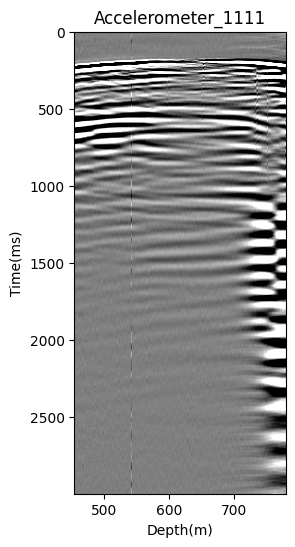

In [7]:
# Plot accelerometer data

pivoted_data_acc = accelerometer_shotpoint_1111.pivot(index='Time', columns='ELEV_REC', values='Amplitude')

plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
plt.imshow(pivoted_data_acc, aspect='auto', cmap='gray', extent=[
           accelerometer_shotpoint_1111['ELEV_REC'].min(), accelerometer_shotpoint_1111['ELEV_REC'].max(), accelerometer_shotpoint_1111['Time'].max(), accelerometer_shotpoint_1111['Time'].min()]
           ,vmin=np.percentile(pivoted_data_acc, 5), 
            vmax=np.percentile(pivoted_data_acc, 95))
plt.xlabel('Depth(m)')
plt.ylabel('Time(ms)')
plt.title('Accelerometer_1111')

depth_acc = accelerometer_shotpoint_1111['ELEV_REC'].unique()
time_acc = accelerometer_shotpoint_1111['Time'].unique()

In [8]:
depth_acc

array([779.2, 778.2, 777.2, 776.2, 775.2, 774.2, 773.2, 772.2, 771.2,
       770.2, 769.2, 768.2, 767.2, 766.2, 765.2, 764.2, 763.2, 762.2,
       761.2, 760.2, 759.2, 758.2, 757.2, 756.2, 755.2, 754.1, 753.1,
       752.1, 751.1, 750.1, 749.1, 748.1, 747.1, 746.1, 745.1, 744.1,
       743.1, 742.1, 741.1, 740.1, 739.1, 738.1, 737.1, 736.1, 735.1,
       734.1, 733.1, 732.1, 731.1, 730.1, 729.1, 728.1, 727.1, 726.1,
       725.1, 724.1, 723.1, 722.1, 721.1, 720.1, 719.1, 718.1, 717.1,
       716.1, 715.1, 714.1, 713.1, 712.1, 711.1, 710.1, 709. , 708. ,
       707. , 706. , 705. , 704. , 703. , 702. , 701. , 700. , 699. ,
       698. , 697. , 696. , 695. , 694. , 693. , 692. , 691. , 690. ,
       689. , 688. , 687. , 686. , 685. , 684. , 683. , 682. , 681. ,
       680. , 679. , 678. , 677. , 676. , 675. , 674. , 673. , 672. ,
       671. , 670. , 669. , 668. , 667. , 666. , 665. , 664. , 663. ,
       661.9, 660.9, 659.9, 658.9, 657.9, 656.9, 655.9, 654.9, 653.9,
       652.9, 651.9,

In [9]:
# Normalize Accelerometer data
Acc_data = normalize(pivoted_data_acc.values)

print(Acc_data.shape[0])

3000


In [10]:
#Reshape data

X = np.zeros((Acc_data.shape[1], Acc_data.shape[0], 1))
for i in range(Acc_data.shape[1]):
    X[i, :, 0] = Acc_data[:, i]

y = depth_acc[::-1]  


In [11]:
# Split data

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_classes = len(np.unique(y_train))

In [13]:
model = Sequential([
    LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    Dense(231, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))

# Evaluate model on test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
predictions = model.predict(x_test)

NameError: name 'X_train' is not defined

In [12]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [13]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=4,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 3000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3000, 1)   │      7,169 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 3000, 1)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3000, 1)   │          2 │ dropout_27[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 3000, 1)   │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 3000, 4)   │          8 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 3000, 4)   │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 3000, 1)   │          5 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3000, 1)   │          2 │ conv1d_17[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 3000, 1)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3000, 1)   │      7,169 │ add_17[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 3000, 1)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3000, 1)   │          2 │ dropout_30[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 3000, 1)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 3000, 4)   │          8 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 3000, 4)   │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 3000, 1)   │          5 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3000, 1)   │          2 │ conv1d_19[0][0]   │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 52,736 (206.00 KB)

 Trainable params: 52,736 (206.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
18/37 ━━━━━━━━━━━━━━━━━━━━ 3:54 12s/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00